In [1]:
import sqlite3
import pandas as pd
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from gensim import corpora
import gensim
import pickle

In [5]:
# nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

Discover the data

In [6]:
con = sqlite3.connect("corona-data.db")
df = pd.read_sql_query("SELECT * FROM initiatives", con, index_col = 'id')

NLP preprocessing

In [7]:
stopwords = nltk.corpus.stopwords.words('Dutch')
stemmer = SnowballStemmer("dutch")

In [8]:
def preprocess(x):
    x = re.sub( '[^a-z0-9]', ' ', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in stopwords]  # remove stopwords
    return ' '.join(x)    

In [9]:
zoekwoorden = {
'vraag': ["demand", "vraag", "hulpvraag"],
'aanbod' : ["aangeboden", "hulpaanbod", "aanbod"]
}
    
def check_regex(x):
    x = re.sub( '[^a-z0-9]', ' ', str(x).lower())
    antwoord = []
    for label, keywords in zoekwoorden.items():
        li = [label for w in x.split() if w in keywords]
        if len(li) != 0:
            antwoord.append(li[0])
    return " ".join(antwoord)

In [10]:
def startpipeline(dataf):
    return dataf.copy()

def preprocess_data(dataf):
    dataf['description'] = dataf['description'].astype(str)
    dataf['group'] = dataf['group'].str.lower()
    return dataf

def add_labels(dataf):
    dataf['label'] = dataf['group'].apply(check_regex)
#     dataf['label'] = dataf['group'].apply(check_regex, args = (aanbod_woorden, 'aanbod'))
    return dataf

def nlp_cleaning(dataf):
    dataf['clean_description'] = dataf['description'].apply(preprocess)
    dataf['stemmed'] = dataf['clean_description'].apply(stemmer.stem)
    dataf['tokenized'] = dataf['stemmed'].apply(word_tokenize)
    return dataf

def tokenize(dataf):
    data

df_result = (df
.pipe(startpipeline)
.pipe(preprocess_data)
.pipe(add_labels)
.pipe(nlp_cleaning))

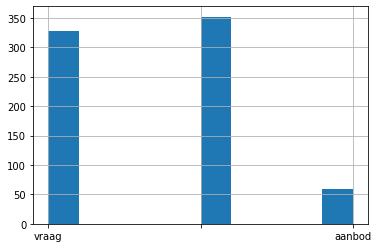

In [11]:
df_result['label'].hist()

Classificatie

In [12]:

vectoriser = TfidfVectorizer()
df_result['vectors'] = list(vectoriser.fit_transform(df_result['stemmed']).toarray())


In [13]:
df_train = df_result[df_result['label'] != ""].copy()
df_predict = df_result[df_result['label'] == ""].copy()

In [14]:
enc = LabelEncoder()
encoded_labels = enc.fit_transform(df_train['label'])
enc.classes_

array(['aanbod', 'vraag'], dtype=object)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_train['vectors'].to_list(), encoded_labels, test_size=0.2)

In [16]:
# model = DecisionTreeClassifier()
model = LinearSVC()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [17]:
model.score(X_test, y_test)

0.8974358974358975

Word2Vec

Topic modelling

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [18]:
text_data = df_result['tokenized']
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [19]:

# 5 topics
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=30)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.022*"non" + 0.016*"mensen" + 0.010*"we" + 0.010*"boodschappen" + 0.008*"contact" + 0.008*"wij" + 0.008*"jij"')
(1, '0.011*"mensen" + 0.010*"hulp" + 0.010*"bewoners" + 0.009*"leuk" + 0.007*"helpen" + 0.007*"wij" + 0.006*"zoek"')
(2, '0.014*"wij" + 0.009*"we" + 0.008*"vrijwilligers" + 0.006*"willen" + 0.005*"ouderen" + 0.005*"corona" + 0.005*"maaltijden"')
(3, '0.010*"we" + 0.009*"boodschappen" + 0.008*"helpen" + 0.006*"onze" + 0.006*"zoek" + 0.005*"wij" + 0.005*"functie"')
(4, '0.014*"we" + 0.014*"ouderen" + 0.012*"functie" + 0.010*"omschrijving" + 0.007*"zorg" + 0.006*"mensen" + 0.006*"moeten"')


In [20]:
# three topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.011*"mensen" + 0.010*"we" + 0.009*"helpen" + 0.008*"ouderen"')
(1, '0.022*"non" + 0.012*"mensen" + 0.007*"onze" + 0.007*"wij"')
(2, '0.012*"we" + 0.011*"wij" + 0.008*"functie" + 0.008*"hulp"')


In [21]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.012*"mensen" + 0.011*"we" + 0.011*"wij" + 0.009*"omschrijving"')
(1, '0.009*"vrijwilligers" + 0.008*"willen" + 0.007*"nederlandse" + 0.006*"wij"')
(2, '0.028*"we" + 0.028*"ouderen" + 0.013*"kaart" + 0.012*"tekening"')
(3, '0.017*"boodschappen" + 0.011*"we" + 0.011*"corona" + 0.010*"hulp"')
(4, '0.011*"hulp" + 0.009*"mensen" + 0.006*"vrijwilliger" + 0.005*"kinderen"')
(5, '0.013*"boodschappen" + 0.010*"functie" + 0.009*"graag" + 0.009*"omschrijving"')
(6, '0.016*"we" + 0.016*"wij" + 0.014*"mensen" + 0.011*"hulp"')
(7, '0.011*"mensen" + 0.009*"boodschappen" + 0.008*"contact" + 0.008*"hulp"')
(8, '0.086*"non" + 0.017*"mensen" + 0.013*"buurt" + 0.012*"maken"')
(9, '0.018*"onze" + 0.010*"wij" + 0.009*"functie" + 0.008*"mevrouw"')


In [ ]:
TFIDF

In [61]:
encoded_labels_p= model.predict(df_predict['vectors'].to_list())
new_labels = enc.inverse_transform(encoded_labels_p)

cvec = CountVectorizer(min_df=.0025, max_df=.1, ngram_range=(1,2))
cvec.fit(df_result.stemmed)
cvec_counts = cvec.transform(df_result.stemmed)

print('sparse matrix shape:{}'.format(cvec_counts.shape))
print('nonzero count:{}'.format(cvec_counts.nnz))
print('sparsity: {}'.format(100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape:(738, 2576)
nonzero count:13872
sparsity: 0.7296874210978135


,term,occurrences
1707,ouderen,99
1639,onze,88
446,contact,85
2296,vrijwilligers,82
843,graag,76
2430,willen,70
2066,tijd,70
1362,maken,68
1072,jij,67
1283,leuk,65


In [124]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
723,functie omschrijving,0.016123
2296,vrijwilligers,0.013357
1707,ouderen,0.012749
843,graag,0.012740
1639,onze,0.012385
1567,nodig,0.011577
284,bewoners,0.011293
854,gratis,0.010835
401,buurt,0.010763
2066,tijd,0.010542


In [127]:
tvec = TfidfVectorizer(min_df=.0025, max_df=.1)
tvec_weights = tvec.fit_transform(df_result['stemmed'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
1419,vrijwilligers,0.015798
1032,ouderen,0.015461
540,graag,0.015311
987,onze,0.014541
945,nodig,0.013618
192,bewoners,0.012864
279,contact,0.012736
1522,zoeken,0.012557
1475,willen,0.012522
249,buurt,0.012388


In [18]:
print(fdist)

id
1      {'talloze': 1, 'instellingen': 1, 'thuiszorgorganisaties': 1, 'ziekenhuizen': 1, 'kort': 1, 'spatbrillen': 1, 'vuurwerkbrillen': 1, 'veiligheidsbrillen': 1, 'voldoen': 1, 'oproep': 1, 'brillen': 1, 'doneren': 1, 'strijd': 1, 'corona': 1, 'hulpvraag': 1, 'zoeken': 1, 'we': 1, 'meerdere': 1, 'held': 1}                                                                                                                                                                                                                                                                                                                            
2      {'hoi': 1, 'mede': 1, 'helden': 1, 'dochter': 1, '31': 1, 'maart': 1, 'particuliere': 1, 'woning': 1, 'contract': 1, 'verloopt': 1, 'zeker': 1, 'tijd': 1, 'niks': 1, 'krijgen': 1, 'volgens': 1, 'woningbouw': 1, 'urgent': 1, 'bent': 1, 'kent': 1, 'omgeving': 1, 'koop': 1, 'huis': 1, 'leeg': 1, 'staan': 2, 'westelijke': 1, 'mijnstreek': 1, 'huren': 1, 'korte': 1, '

In [222]:
fdist.most_common(5)

AttributeError: 'Series' object has no attribute 'most_common'